In [1]:
import numpy as np
import pandas_profiling
import category_encoders
import decode
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#NotebookApp.iopub_data_rate_limit=10000000.0

In [2]:
creature_blocks = decode.get_creature_blocks()
creature_blocks2 = decode.get_creature_blocks('monstersbook2')

# updates creature blocks to contain all records
creature_blocks.update(creature_blocks2)
print (len (creature_blocks))
creature_blocks2 = _

413  creatures loaded!
335  creatures loaded!
748


In [3]:
try:    
    creature_blocks.pop('CREATURE')
    creature_blocks.pop('CREATURE')
    creature_blocks.pop('READING')
except:
    pass

print(len(creature_blocks))
print(creature_blocks["ZOMBIE HULK"])
print()
print(creature_blocks["THELETOS"])

747
{'name': 'ZOMBIE HULK CREATURE 6', '1': 'NE HUGE MINDLESS UNDEAD ZOMBIE', '3': 'Perception +8; darkvision', '5': 'Skills Athletics +18', '6': 'Str +7, Dex -1, Con +4, Int -5, Wis +0, Cha -2', '7': 'Slow As zombie shambler.', '8': 'AC 21; Fort +16, Ref +9, Will +12', '9': 'HP 160, negative healing; Immunities death effects, disease,', '10': 'Speed 25 feet', '11': 'Melee [one-action] hunk of meat +17 (reach 15 feet), Damage 2d10+9 bludgeoning', '15': 'Attack of Opportunity [reaction] Trigger A creature within the', '12': 'Engulf [two-actions]The monster Strides up to double its Speed and can', '14': 'Improved Grab, Improved Knockdown, or Improved Push[free-action] The', '13': 'Trample[three-actions] The monster Strides up to double its Speed and'}

{'name': 'THELETOS CREATURE 7', '1': 'LN MEDIUM AEON MONITOR', '3': 'Perception +18; darkvision', '4': 'Languages envisioning', '5': 'Skills Arcana +16, Intimidation +16, Religion +18, Stealth +15', '6': 'Str +4, Dex +4, Con +3, Int +3, Wi

In [4]:
def creature_blocks_to_df(creature_blocks):
    df_dict={}
    for name,info in creature_blocks.items():
        #print(name,info)
        #name= creature
        creature_record = {}

        creature_record["level"] = info['name'].split(' ')[-1]

        if '1' in info.keys():
            creature_record["size"] = info['1'].split(' ')[1]    
            creature_record["alignment"] = info['1'].split(' ')[0]
        else:            
            creature_record["size"] = info['2'].split(' ')[2]    
            creature_record["alignment"] = info['2'].split(' ')[1]

        creature_record["perception"] = info['3'].split(' ')[1].replace(";","")
        creature_record["perception"]=creature_record["perception"].replace(",","")

        try:
            int(creature_record["perception"])
        except:
            print('invalid perception: ',name,creature_record["perception"])



        stats = info['6'].replace(',','')
        stats = re.split("\s|(?<!\d)[,.](?!\d)", str(stats))
        #print (info)
        try:
            creature_record["Str"] = int(stats[1])
            creature_record["Dex"] = int(stats[3])
            creature_record["Con"] = int(stats[5])
            creature_record["Int"] = int(stats[7])
            creature_record["Wis"] = int(stats[9])
        except:
            print("error,",stats,info)
        try:
            creature_record["Cha"] = int(stats[11])
        except:
            creature_record["Cha"] = int(stats[12])
        df_dict[name]= creature_record
    return pd.DataFrame.from_dict(df_dict,orient='index')

In [5]:

def get_feature_type_lists(df,target= 'alignment'):
    categorical_features = []
    numeric_features = []
    df=df.astype(str)
    for i in df:
        
        try:        
            df[i]=pd.to_numeric(df[i])
            if i !=target:
                numeric_features.append(i)
            print (i,'is numeric')
        except:
            if i !=target:
                categorical_features.append(i)
            print (i,'is categorical')
    return categorical_features,numeric_features

In [6]:
full_df = creature_blocks_to_df(creature_blocks)

In [7]:
full_df.head(5)

level    size alignment perception  Str  Dex  Con  Int  Wis  Cha
ARBITER      1    TINY        LN         +7    1    4    2    0    2    1
AXIOMITE     8  MEDIUM        LN        +19    5    4    3    5    5    3
KOLYARUT    12  MEDIUM        LN        +23    7    4    5    1    4    2
PLEROMA     20   LARGE        LN        +37    6    7    6    8    9    6
SKUM         2  MEDIUM        LE         +6    4    1    3    0    0   -2

In [8]:
pandas_profiling.ProfileReport(full_df)

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# drop very rare targets
for alignment in full_df.alignment.value_counts()[full_df.alignment.value_counts()<=5].index:
    full_df=full_df[full_df.alignment!=alignment]

In [10]:
target= 'alignment'

from sklearn.preprocessing import LabelEncoder

def feature_target_split(df,target='alignment'):
    try:
        #label_enc = LabelEncoder()
        #y=label_enc.fit_transform(df[target])
        y=df[[target]]
        df.drop(columns=target,inplace=True)
    except:
        pass
    return df,y

X,y = feature_target_split(full_df)

target_labels=y.alignment.value_counts().index.to_list()
y= y.alignment

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,
                                                    stratify=y,
                                                    test_size=0.25)

X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,random_state=42,
                                                    stratify=y_test,
                                                    test_size=0.5)

In [11]:
crossval_X = X_train.append(X_test);crossval_y = y_train.append(y_test)

In [12]:
categorical_features,numeric_features =get_feature_type_lists(X_train)

level is numeric
size is categorical
perception is numeric
Str is numeric
Dex is numeric
Con is numeric
Int is numeric
Wis is numeric
Cha is numeric


In [13]:
(y_train   == 'N').value_counts(normalize=True)

False    0.586022
True     0.413978
Name: alignment, dtype: float64

In [14]:
# linear logistic regression
LinLogReg = LogisticRegression()
LinLogReg.fit(X_train.Int.to_numpy().reshape(-1,1),y_train == 'N')

print('Training Accuracy: ',LinLogReg.score(X_train.Int.to_numpy().reshape(-1,1),y_train == 'N'))
print('Validation Accuracy:',LinLogReg.score(X_val.Int.to_numpy().reshape(-1,1),  y_val   == 'N'))

Training Accuracy:  0.8279569892473119
Validation Accuracy: 0.8602150537634409


In [15]:
# linear logistic regression
LinLogReg = LogisticRegression()
LinLogReg.fit(X_train[numeric_features],y_train == 'N')

print('Training Accuracy: ',LinLogReg.score(X_train[numeric_features],y_train == 'N'))
print('Validation Accuracy:',LinLogReg.score(X_val[numeric_features],  y_val   == 'N'))

Training Accuracy:  0.8440860215053764
Validation Accuracy: 0.8709677419354839


In [16]:
y_train.value_counts(normalize=True)

N     0.413978
CE    0.216846
NE    0.114695
LE    0.098566
CN    0.044803
CG    0.032258
LG    0.028674
NG    0.025090
LN    0.025090
Name: alignment, dtype: float64

In [17]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [18]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier',RandomForestClassifier(n_estimators=1000,max_depth=4) )])

clf.fit(X_train,y_train)
print('Train accuracy:      ',clf.score(X_train,y_train))
print('Validation accuracy: ',clf.score(X_val,y_val))

Train accuracy:       0.543010752688172
Validation accuracy:  0.5591397849462365


In [19]:

#from sklearn.model_selection import cross_validate
#cv = cross_validate(clf,X_train,y_train,return_train_score=True,cv=10,return_estimator=True)
#cv_estimator = cv['estimator'][0]

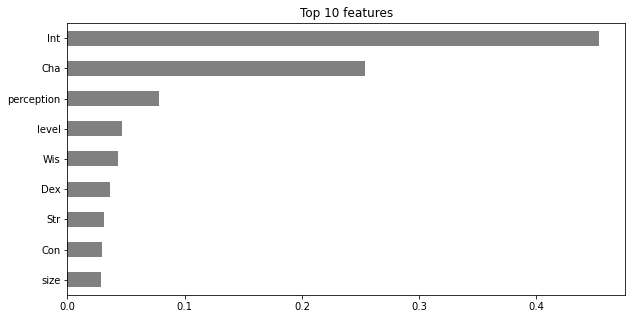

In [20]:
# Features (order in which they were preprocessed)
features_order = numeric_features + categorical_features

importances = pd.Series(clf[-1].feature_importances_, features_order)

# Plot feature importances
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

plt.show()

In [21]:
val_score = clf.score(X_val,y_val)

# Permute the values in the more important column
feature = 'Cha'

X_val_permuted = X_val.copy()

# Fill in missing values
#X_test_permuted[feature].fillna(value = X_test_permuted[feature].median(), inplace=True)

# Permute
X_val_permuted[feature] = np.random.permutation(X_val[feature])
permuted_val_score = clf.score(X_val_permuted,y_val)

print('Feature permuted: ', feature)
print('Validation Accuracy', val_score)
print('Validation Accuracy (permuted)', permuted_val_score)
print('Usefulness: '+str(val_score-permuted_val_score))

Feature permuted:  Cha
Validation Accuracy 0.5591397849462365
Validation Accuracy (permuted) 0.5053763440860215
Usefulness: 0.053763440860215006


In [22]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier

clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier',
                  AdaBoostClassifier(n_estimators=1000, learning_rate=.1, random_state=42)
                  )])

cv = cross_validate(clf,crossval_X,crossval_y,return_train_score=True,return_estimator=True,cv=5,n_jobs=-1)
#cv
ada_cv_estimator = cv['estimator'][-1][-1]


In [23]:
print('Validation Accuracy: Adaboost', cv['test_score'].mean())

Validation Accuracy: Adaboost 0.33443335290663534


In [24]:
from xgboost import XGBClassifier

xg_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier',
                   XGBClassifier(n_estimators=100, random_state=42,objective='multi:softmax',
                                 use_label_encoder=True, eval_metric='mlogloss')
                  )])

xgb_cv = cross_validate(xg_classifier,crossval_X,crossval_y.tolist(),return_train_score=True,cv=7,return_estimator=True,n_jobs=-1)

xgb_cv_estimator = xgb_cv['estimator'][-1][-1]
#print(len(cv['estimator']))
print('Validation Accuracy: XGB', cv['test_score'].mean())

Validation Accuracy: XGB 0.33443335290663534


In [25]:

#preped_data = preprocessor.fit_transform(df,y)

preped_data= pd.DataFrame(preprocessor.fit_transform(crossval_X,crossval_y))
preped_data.columns=numeric_features + categorical_features

import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    ada_cv_estimator,
    cv= None,
    n_iter=5,
    random_state=42)
permuter.fit(preped_data, crossval_y)

permuter.feature_importances_
print("Ada_CV")
eli5.show_weights(    
    permuter,    
    top=None,
    feature_names=numeric_features + categorical_features
)

Ada_CV


In [26]:

#preped_data = preprocessor.fit_transform(df,y)

preped_data= pd.DataFrame(preprocessor.fit_transform(crossval_X,crossval_y))
preped_data.columns=numeric_features + categorical_features

import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    xgb_cv_estimator,
    cv= None,
    n_iter=5,
    random_state=42)
permuter.fit(preped_data, crossval_y)

permuter.feature_importances_
print("Xgb_CV")
eli5.show_weights(    
    permuter,    
    top=None,
    feature_names=numeric_features + categorical_features
)

C:\Users\Tasha\.conda\envs\Lambda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Xgb_CV


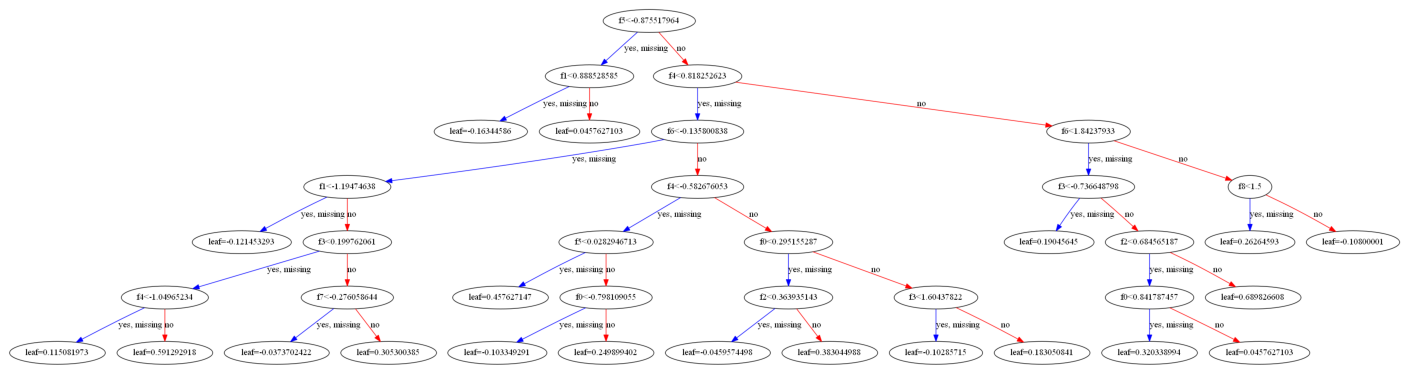

In [27]:
from xgboost import plot_tree

fig,ax = plt.subplots(figsize=(25,25))
a=plot_tree(xgb_cv_estimator,num_trees=0,ax=ax)

In [28]:
xg_classifier.fit(X_train,y_train)
print(xg_classifier.score(X_train,y_train))
print(xg_classifier.score(X_val,y_val))
xg_classifier.predict(X_train.iloc[0:10])

C:\Users\Tasha\.conda\envs\Lambda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.996415770609319
0.43010752688172044


array(['N', 'CE', 'CE', 'CE', 'CN', 'N', 'N', 'N', 'CE', 'N'],
      dtype=object)

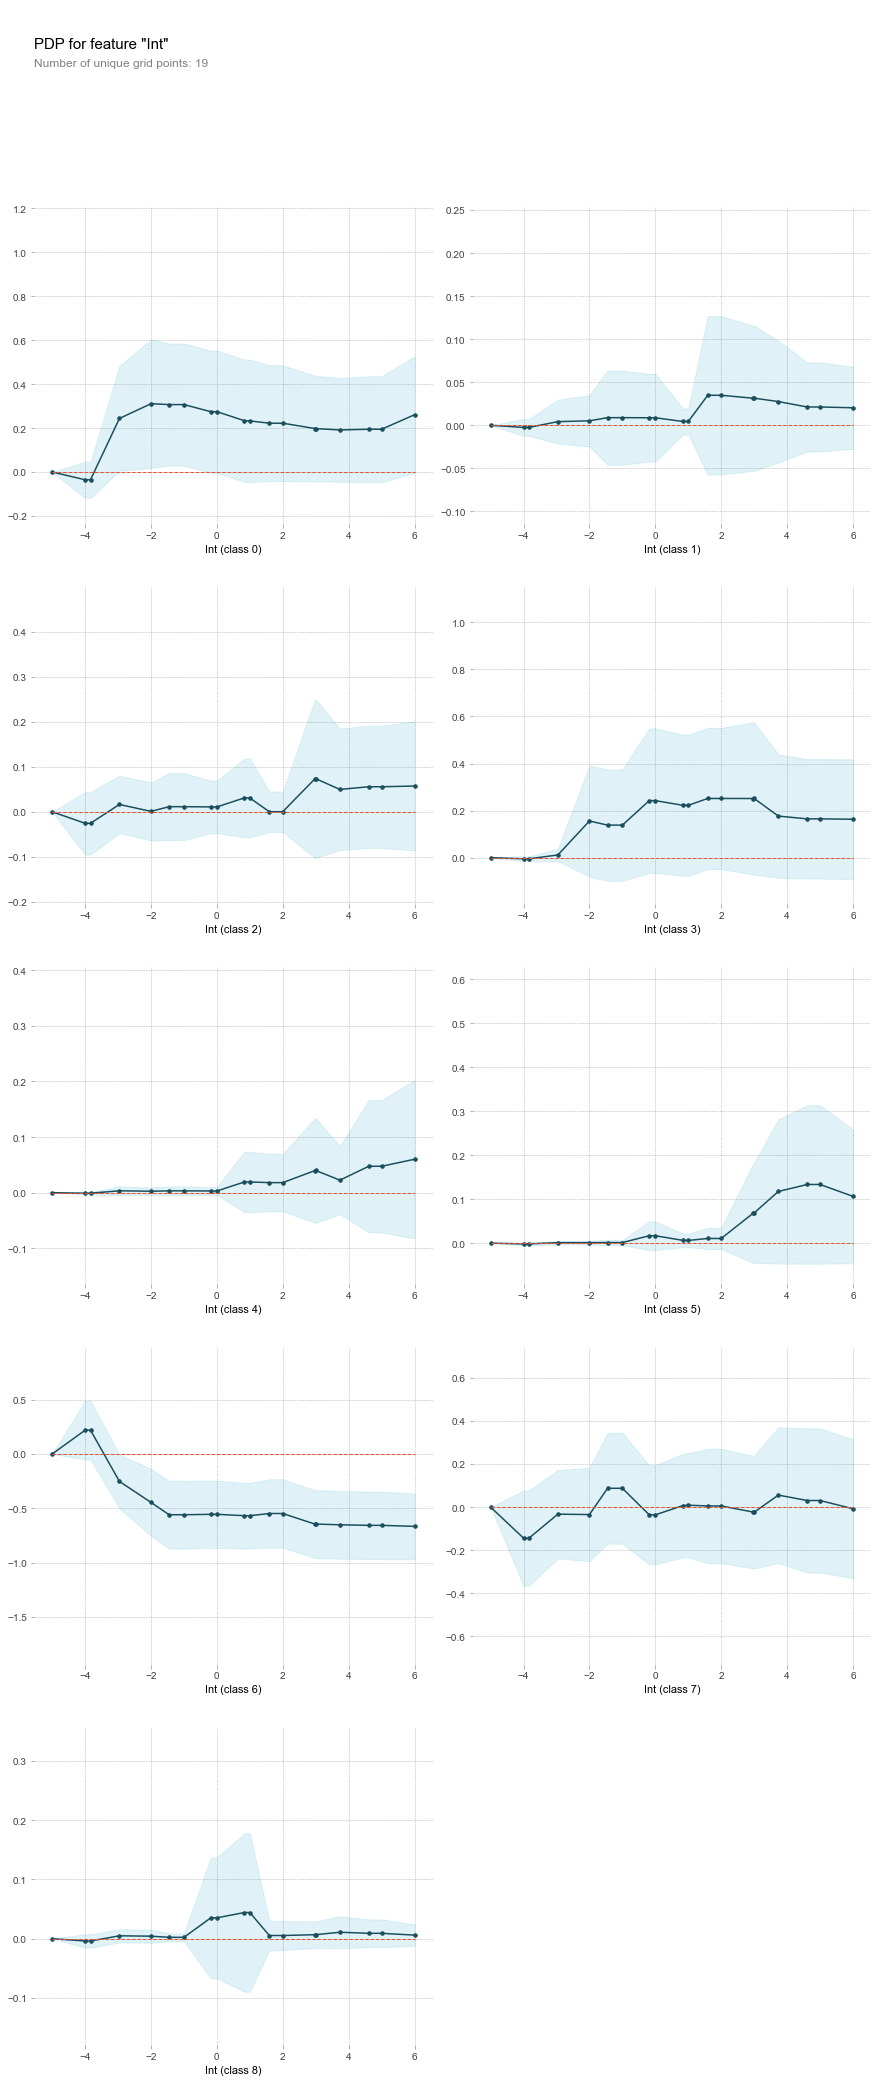

In [29]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Int'

isolated = pdp_isolate(
    model=xg_classifier, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    num_grid_points=50
)
pdp_plot(isolated, feature_name=feature, plot_lines=False, frac_to_plot=1.0);

In [30]:
import shap 

In [31]:
creature_idx=3
alignment_num=0

creature = preped_data[creature_idx:creature_idx+1]
explainer = shap.TreeExplainer(xg_classifier[-1])
shap_values = explainer.shap_values(creature)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[alignment_num], 
    shap_values=shap_values[alignment_num], 
    features=creature)


Validation accuracy:  0.41935483870967744 iterations:  1 
 {'max_depth': 753, 'min_samples_split': 417, 'min_samples_leaf': 227, 'min_weight_fraction_leaf': 0.07142125714008468, 'max_leaf_nodes': 469, 'min_impurity_decrease': 0.2704176508834021, 'min_impurity_split': 0.24726081251505694, 'bootstrap': 0}
Validation accuracy:  0.4946236559139785 iterations:  477 
 {'max_depth': 997, 'min_samples_split': 262, 'min_samples_leaf': 36, 'min_weight_fraction_leaf': 0.23817052518712545, 'max_leaf_nodes': 636, 'min_impurity_decrease': 0.02485204761286286, 'min_impurity_split': 0.6273759936403196, 'bootstrap': 1}
Validation accuracy:  0.5268817204301075 iterations:  698 
 {'max_depth': 533, 'min_samples_split': 490, 'min_samples_leaf': 150, 'min_weight_fraction_leaf': 0.3612676567283196, 'max_leaf_nodes': 472, 'min_impurity_decrease': 0.0013249683347423824, 'min_impurity_split': 0.4169594588770619, 'bootstrap': 0}
Validation accuracy:  0.5376344086021505 iterations:  856 
 {'max_depth': 533, 'min

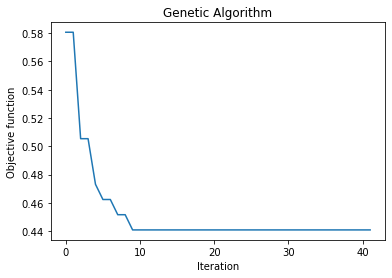

In [68]:
# time to do some hyperparameter tuning
# our best performing model so far is the random forest classifier so we should start with that.
from geneticalgorithm import geneticalgorithm as ga

hyperparams={
    'max_depth':1,
    'min_samples_split':2,
    'min_samples_leaf':1,
    'min_weight_fraction_leaf':0.0,
    'max_leaf_nodes':None,
    'min_impurity_decrease':0.0,
    'min_impurity_split':None,
    'bootstrap':True,
    #'oob_score':False,
    #'warm_start':False,    
    #'ccp_alpha':0.0,
    #'max_samples':None,
}

best = 0
iterations =0
def f(x):
    global best,model,iterations
    for i,kv in enumerate(hyperparams.items()):
        fixed_x = x[i]
        if fixed_x % 1 ==0:
            fixed_x =fixed_x.astype('int')
            
        hyperparams[kv[0]]=fixed_x
        
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier',RandomForestClassifier(
                      n_estimators=40,**hyperparams,
                      n_jobs=16,
                      #class_weight='balanced_subsample',
                  ) )])

    clf.fit(X_train,y_train)
    iterations=iterations+1
    if iterations % 200 ==0:
        print ("iterations: ",iterations)
    val_score=clf.score(X_val,y_val)    
    if val_score>best:
        print('Validation accuracy: ',val_score,"iterations: ",iterations,
              '\n',hyperparams
             )
        best=val_score
        
    return 1-val_score


varbound=np.array([
    [1,1000],  # max_depth
    [2,1000],  # min_samples_split
    [1,1000],  # min_samples_leaf
    [0,.5],   # min_weight_fraction_leaf
    [2,1000],# max_leaf_nodes
    [0,1],   # min_impurity_decrease
    [0,1],   # min_impurity_split
    [0,1],   # bootstrap
])
algorithm_parameters={'max_num_iteration': None,
                      'population_size': 100,
                      'mutation_probability': 0.3,
                      'elit_ratio': 0.02,
                      'crossover_probability': 0.3,
                      'parents_portion': 0.3,
                      'crossover_type': 'uniform',
                      'max_iteration_without_improv': 30,                      
                     }
vartypes= np.array(['int','int','int','real','int','real','real','int'] )
model=ga(function=f,
         dimension=8,
         variable_type_mixed=vartypes,
         variable_boundaries=varbound,
         algorithm_parameters=algorithm_parameters,
         progress_bar=False)
model.run()
#Hyper_GA = ga(f,3)

In [71]:
params = {'max_depth': 297,
          'min_samples_split': 118,
          'min_samples_leaf': 123,
          'min_weight_fraction_leaf': 0.40871409666494896,
          'max_leaf_nodes': 900,
          'min_impurity_decrease': 0.02428287055453838,
          'min_impurity_split': 0.6004478563616913,
          'bootstrap': 0}


In [77]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
              ('classifier',RandomForestClassifier(
                  n_estimators=20000,**params,
                  n_jobs=16,                  
              ) )])

clf.fit(X_train,y_train)
val_score=clf.score(X_val,y_val)    
test_score = clf.score(X_test,y_test)
iterations=iterations+1
print('Validation accuracy: ',val_score)
print('Test accuracy: ',test_score)
        

Validation accuracy:  0.5591397849462365
Test accuracy:  0.5531914893617021
